In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figures').absolute()

df_meta_path = data_dir /'tissue'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
df_imgs = df_imgs[df_imgs.FOV == '40X']

In [6]:
df_imgs

Condition  FOV                                               Path
1  577-1197  40X  y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
3  577-1210  40X  y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...

# Test image viz

In [11]:
# df_imgs = df_imgs[df_imgs['FOV'] == '40X']

In [13]:
path = df_imgs.iloc[0].Path

In [14]:
with h5py.File(path, 'r') as f:
    markers = f['imgs'].attrs['Marker']
    # imgs = f['imgs'][:]
    

In [15]:
markers

array(['Hoechst', 'Sox2/Oct4', 'NF-Kb/p-P90rsk', 'Hoechst',
       'Cyclin D1/CDK4', 'TRAIL/DR5', 'Hoechst', 'p-ERK/c-MYC', 'Hoechst',
       'Cyclin E/CDK2', 'Hoechst', 'CD20', 'CD8', 'Hoechst',
       'Pan-cytokeratin', 'CD4', 'Hoechst', 'Concanavalin A', 'WGA',
       'HE1', 'HE2', 'HE3'], dtype=object)

In [13]:
napari.view_image(imgs, name=markers, visible=False, channel_axis=0, contrast_limits=[0,2**16])

Viewer(camera=Camera(center=(0.0, 13352.0, 15613.5), zoom=0.009187267836556934, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 26705.0, 1.0), (0.0, 31228.0, 1.0)), current_step=(13352, 15613), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Hoechst' at 0x1baa767ced0>, <Image layer 'Sox2/Oct4' at 0x1baa70aa450>, <Image layer 'NF-Kb/p-P90rsk' at 0x1baa69f3e50>, <Image layer 'Hoechst [1]' at 0x1baa6450c10>, <Image layer 'Cyclin D1/CDK4' at 0x1baa6a0c3d0>, <Image layer 'TRAIL/DR5' at 0x1ba9fe0cb90>, <Image layer 'Hoechst [2]' at 0x1ba9fe2f610>, <Image layer 'p-ERK/c-MYC' at 0x1ba9fe56010>, <Image layer 'Hoechst [3]' at 0x1ba9fe88990>, <Image layer 'Cyclin E/CDK2' at 0x1ba9fe0cbd0>, <Image layer 'Hoechst [4]' at 0x1baa0269bd0>, <Image layer

# Generate scatter dot

In [48]:
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [49]:
df_imgs

Condition  FOV                                               Path
1  577-1197  40X  y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
3  577-1210  40X  y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...

In [54]:
# Read PPI
PPI_save_path =  data_dir / 'tissue' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'all' in path:
        continue
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [55]:
df

Cyto     x      y            PPI Condition  FOV
0     2207   988  11013      Sox2/Oct4  577-1197  40X
1     5383  2427  10828      Sox2/Oct4  577-1197  40X
2      172    73   7263      Sox2/Oct4  577-1197  40X
3     5886  2717   7532      Sox2/Oct4  577-1197  40X
4     3597  1610   6585      Sox2/Oct4  577-1197  40X
...    ...   ...    ...            ...       ...  ...
9544  2446  1964   5236  Cyclin E/CDK2  577-1210  40X
9545  3861  2864   6408  Cyclin E/CDK2  577-1210  40X
9546   427   872   4749  Cyclin E/CDK2  577-1210  40X
9547  5957  4817   2658  Cyclin E/CDK2  577-1210  40X
9548  1408  1342   1395  Cyclin E/CDK2  577-1210  40X

[38218 rows x 6 columns]

In [56]:
PPI_cycles = [['Sox2/Oct4', 'NF-Kb/p-P90rsk'], ['Cyclin D1/CDK4', 'TRAIL/DR5'],
       ['Cyclin E/CDK2']]

## 577-1197

In [57]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


Condition                                             577-1197
FOV                                                        40X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 1, dtype: object


In [58]:
df.PPI.unique()

array(['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'Cyclin D1/CDK4', 'TRAIL/DR5',
       'Cyclin E/CDK2'], dtype=object)

In [59]:
df.columns = ['Cyto',  'row', 'column', 'PPI', 'Condition', 'FOV']

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 10214,974
x_max, y_max = 11210,1914
DAPI_ch = 0

In [61]:
# # Get ppi location
# points = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, 'Sox2/Oct4') 

# # Napari viewerdd
# # Napari 
# viewer = napari.view_image(imgs[[0,list(markers).index('Sox2/Oct4')], y_min:y_max, x_min:x_max], channel_axis=0, colormap=['blue', 'magenta',], contrast_limits=[[0, 255**2], [0, 255**2]])
# points_layer = viewer.add_points(points, size=12,face_color='lime')

In [63]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

colors = ['magenta', 'lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='blue')
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=12,face_color=colors[j],)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'patient_1197_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_8596\4000143242.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'patient_1197_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_8596\4000143242.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'patient_1197_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_8596\4000143242.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'patient_1197_{i}.tif', removeBorders(screenshot))


## 577-1210

In [64]:
# Get images
index = 1
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    imgs = f['imgs'][:]
    markers = f['imgs'].attrs['Marker']


Condition                                             577-1210
FOV                                                        40X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 3, dtype: object


In [65]:
df.PPI.unique()

array(['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'Cyclin D1/CDK4', 'TRAIL/DR5',
       'Cyclin E/CDK2'], dtype=object)

In [67]:
df.columns = ['Cyto',  'row', 'column', 'PPI', 'Condition', 'FOV']

image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'
image_dir.mkdir(parents=True, exist_ok=True)

# Define matching bbox to figures
x_min, y_min = 1204, 4185
x_max, y_max = 3020, 5449
DAPI_ch = 0

In [68]:
# # Get ppi location
# points = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, 'Sox2/Oct4') 

# # Napari viewerdd
# # Napari 
# viewer = napari.view_image(imgs[[0,list(markers).index('Sox2/Oct4')], y_min:y_max, x_min:x_max], channel_axis=0, colormap=['blue', 'magenta',], contrast_limits=[[0, 255**2], [0, 255**2]])
# points_layer = viewer.add_points(points, size=12,face_color='lime')

In [69]:
# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

colors = ['magenta', 'lime']
# Get ppi location
for i, PPI_names in enumerate(PPI_cycles):
    points = [get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_name) for PPI_name in PPI_names]

    # Napari viewer
    viewer = napari.view_image(dapiImg, colormap='blue')
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=12,face_color=colors[j],)

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'patient_1210_{i}.tif', removeBorders(screenshot))


C:\Users\thu71\AppData\Local\Temp\ipykernel_8596\962172978.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'patient_1210_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_8596\962172978.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'patient_1210_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_8596\962172978.py:18: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'patient_1210_{i}.tif', removeBorders(screenshot))


# PLA quantification

In [7]:
import PLA

PPI_save_path =  data_dir / 'tissue' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

PPI_imgs_path =  data_dir / 'tissue' / 'PPI_imgs'
PPI_imgs_path.mkdir(parents=True, exist_ok=True)

In [8]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)
    break


['Hoechst' 'Sox2/Oct4' 'NF-Kb/p-P90rsk' 'Hoechst' 'Cyclin D1/CDK4'
 'TRAIL/DR5' 'Hoechst' 'p-ERK/c-MYC' 'Hoechst' 'Cyclin E/CDK2' 'Hoechst'
 'CD20' 'CD8' 'Hoechst' 'Pan-cytokeratin' 'CD4' 'Hoechst' 'Concanavalin A'
 'WGA' 'HE1' 'HE2' 'HE3']


In [9]:
PPI_markers = ['Sox2/Oct4', 'NF-Kb/p-P90rsk',  'Cyclin D1/CDK4',
 'TRAIL/DR5', 'p-ERK/c-MYC','Cyclin E/CDK2']

In [10]:
thresholds = [0.03, 0.03, 0.07, 0.07, 0.2, 0.2]

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='imgs', m='Marker')
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    imgs_raw = []
    for i,RNA in enumerate(PPI_markers): 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=thresholds[i], min_radius=2)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
            imgs_raw.append(img)
   
    # Save imgs
    if row.FOV == '40X':
        file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_raw.tiff')
        tiff.imwrite(file_path, np.stack(imgs_raw))
        file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_processed.tiff')
        tiff.imwrite(file_path, np.stack(imgs_wths))
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_detected.tiff')
    tiff.imwrite(file_path, np.stack(imgs_spots))

    # Save PPI dict
    name = '_'.join(row[1:3]) +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)

Reading image Sox2/Oct4
Processing image Sox2/Oct4


KeyboardInterrupt: 

In [11]:
# file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_processed.tiff')
# tiff.imwrite(file_path, np.stack(imgs_wths))
# file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_detected.tiff')
# tiff.imwrite(file_path, np.stack(imgs_spots))

In [12]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(imgs_raw))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

# Assign PPI to cell

In [38]:
import pickle 
from sklearn.neighbors import NearestNeighbors

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

def plot_spot_on_image(reference, spots, labels, spacing=1, radius=1):
        spot_img = np.zeros_like(reference)
        coords = (spots[:, :3] / spacing).astype(int)
        r = radius  # shorthand
        for i, coord in enumerate(coords):
            slc = tuple(slice(x-r, x+r) for x in coord)
            spot_img[slc] = labels[i]
        return spot_img

def nearest_cell(x_pixel, y_pixel, 
                 x_neighborhood_min_pixel,
                 y_neighborhood_min_pixel,
                 mask_array,
                 min_dist=10):
    """Check if nearest nucleus is within user-specified distance.
       If function returns 0, it means no suitable nucleus was found."""

    # When we take a neighborhood slice of mask_array, all indices start at (0,0,0).
    # This INDEX_SHIFT is necessary to reconstruct coordinates from original mask_array.
    INDEX_SHIFT = np.array([x_neighborhood_min_pixel, 
                            y_neighborhood_min_pixel])
    cell_id = 0
    
    samples = np.stack(np.where(mask_array>0)).T
    neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
    neigh.fit(samples)

    data = np.array([x_pixel, y_pixel]) - INDEX_SHIFT
    d, indice = neigh.kneighbors([data])
    d = d[0]
    indice = indice[0]
    if d < min_dist:
        cell_id = mask_array[samples[indice][0][0], samples[indice][0][1]]
    return cell_id

In [39]:

PPI_save_path =  data_dir / 'tissue' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [54]:
min_dist = 20

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read cell mask
    mask_path = mask_dir / f'{row[1]}_cell.png'
    mask = skimage.io.imread(mask_path)
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

    dfs_PPI_cyto = []
    
    mask_dims = {"x_size": mask.shape[0], "y_size": mask.shape[1]}

    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)

        # Cyto
        PPI_labels = mask[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        df_PPI_ori = df_PPI.copy()

        for index in tqdm(range(len(df_PPI))):
            if df_PPI.loc[index, 'Cyto'] != 0:
                continue
            x_pixel, y_pixel = df_PPI.loc[index, ['x', 'y']]

            # Define neighborhood boundary for 3D ndarray slicing. Take image boundary into
            # consideration to avoid negative index.
            y_neighborhood_min_pixel = max(0, round(y_pixel-min_dist))
            y_neighborhood_max_pixel = min(mask_dims["y_size"], round(y_pixel+min_dist+1))
            x_neighborhood_min_pixel = max(0, round(x_pixel-min_dist))
            x_neighborhood_max_pixel = min(mask_dims["x_size"], round(x_pixel+min_dist+1))
            
            # If no cell mask in pixel neighborhood skip
            mask_temp = mask[x_neighborhood_min_pixel : x_neighborhood_max_pixel, y_neighborhood_min_pixel : y_neighborhood_max_pixel]
            if mask_temp.sum() == 0:
                continue
        
            cell_id = nearest_cell(x_pixel, y_pixel,
                                   x_neighborhood_min_pixel,
                                   y_neighborhood_min_pixel,
                                   mask_temp,
                                   min_dist = min_dist
                                  )
            df_PPI.loc[index, 'Cyto'] = cell_id

        dfs_PPI_cyto.append(df_PPI)
            
    # Combined DFs
    df_merged = pd.concat(dfs_PPI_cyto)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)


  0%|          | 0/22166 [00:00<?, ?it/s]

  0%|          | 0/5732 [00:00<?, ?it/s]

  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4228 [00:00<?, ?it/s]

  0%|          | 0/2455 [00:00<?, ?it/s]

  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/1704 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [51]:
# spots = df_PPI_ori[['x', 'y']].values
# labels = df_PPI_ori['Cyto'].tolist()
# img_ori = plot_spot_on_image(mask, spots, labels, radius=2)

In [52]:
# spots = df_PPI[['x', 'y']].values
# labels = df_PPI['Cyto'].tolist()
# img_new = plot_spot_on_image(mask, spots, labels, radius=2)

In [53]:
# viewer = napari.view_labels(mask)
# viewer.add_labels(img_ori)
# viewer.add_labels(img_new)

<Labels layer 'img_new' at 0x1bdf1309b20>

# Cell type definition

## Extract IF channel intensities

In [135]:
import skimage 
from functools import reduce
from skimage import exposure

def read_intensity_per_cell(img, marker, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity"]
    )
    df_prop = pd.DataFrame(props)
    df_prop["mean_intensity"] = df_prop["mean_intensity"]
    df_prop.columns = ["Cell_label", marker]
    return df_prop

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (50, 99.9))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale

In [136]:
df_imgs = df_imgs[df_imgs.FOV == '40X']

In [137]:
# Define cell mask dir
mask_dir =  data_dir / 'tissue' / 'masks'

IF_markers = ['CD8','Pan-cytokeratin','CD4']

df_all = []
centroids = []
for row in df_imgs.itertuples():
    path = row.Path

    # Get IF images 
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    # Read cell mask
    mask_path = mask_dir / f'{row[1]}_cell.png'
    mask = skimage.io.imread(mask_path)
    
    df_props = []
    for i, m in enumerate(markers):
        if m in IF_markers:
            img = contrast_stretching(imgs[i])
            df_prop = read_intensity_per_cell(img, m, mask)
            df_props.append(df_prop)

    df_cell_intensity = reduce(
        lambda left, right: pd.merge(left, right, on=["Cell_label"]),
        df_props,
    )
    df_cell_intensity["Condition"] = row[1]
    df_all.append(df_cell_intensity)
    
    # Get spatial info
    props = skimage.measure.regionprops_table(
        mask, properties=["label", "centroid"]
    )
    rows = props["centroid-0"] 
    cols = props["centroid-1"] 
    centroid = np.array(list(zip(cols, rows)))
    centroids.append(centroid)

centroids_all = np.concatenate(centroid)

## Convert to scanpy and clustering

In [138]:
import scanpy as sc

# Append data
df_intensity = pd.concat(df_all, ignore_index=True)
cent = np.concatenate(centroids)

# Create annData from dataframe
adata = sc.AnnData(df_intensity[IF_markers].values)
adata.var_names = IF_markers  # add variable name

# Add obs information
adata.obs["Condition"] = df_intensity.Condition.tolist()
adata.obs["Cell"] = df_intensity.Cell_label.tolist()
adata.obsm["spatial"] = np.array(cent)

path = data_dir / 'tissue' / 'metadata' / 'cells.h5ad'
adata.write(path)

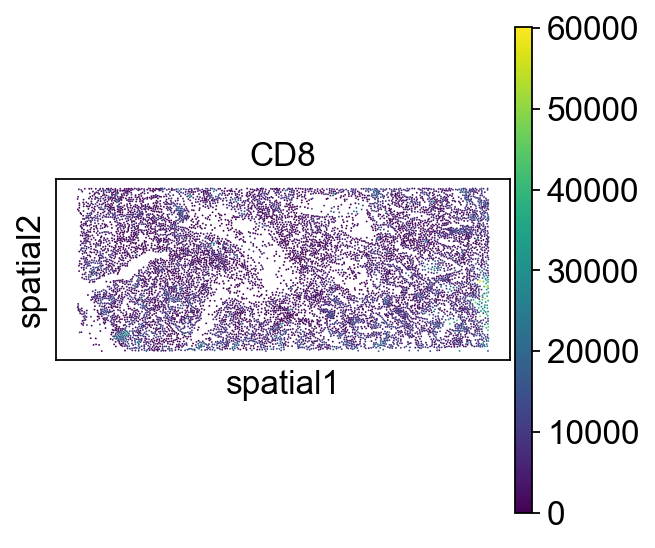

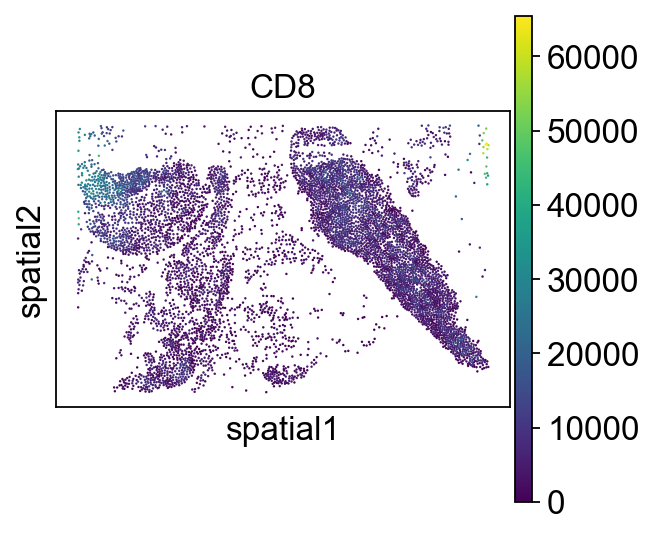

In [139]:
for cond in adata.obs.Condition.unique():
    adata_subset = adata[adata.obs.Condition == cond]
    sc.pl.spatial(adata_subset, color='CD8', spot_size=50)

In [154]:
sc.pp.scale(adata, max_value = 4)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

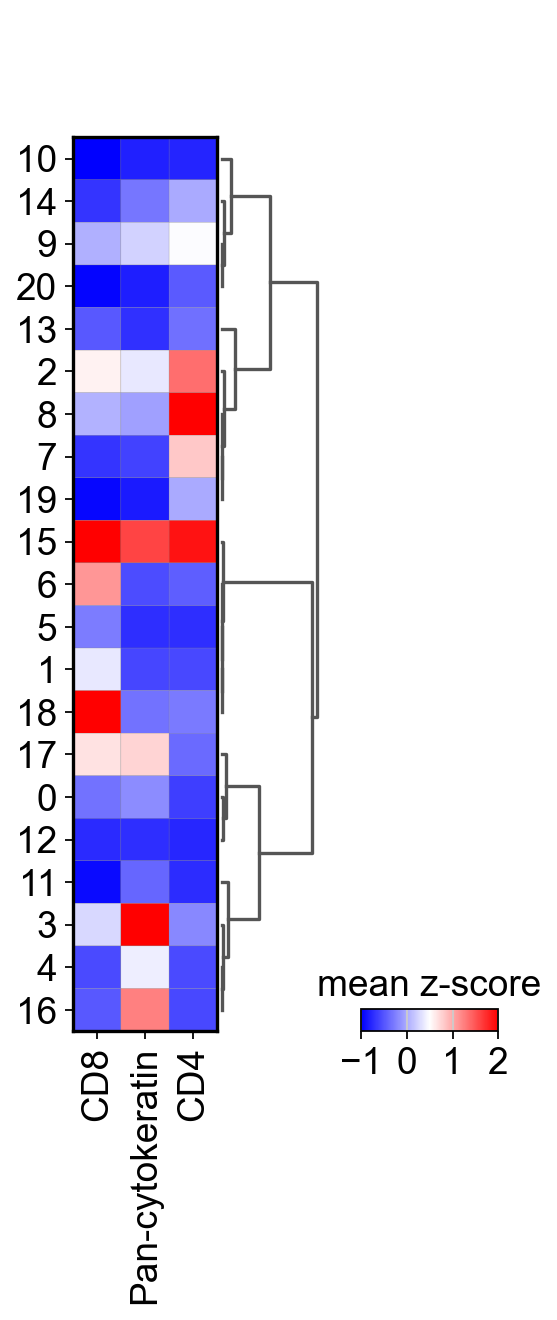

In [155]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.set_figure_params( fontsize=20)
ax_dict = sc.pl.matrixplot(adata, adata.var_names, 'leiden', dendrogram=True,
                 colorbar_title='mean z-score', cmap='bwr', show=False, vmax=2)
ax_dict['mainplot_ax'].tick_params(axis='x', labelrotation=90)


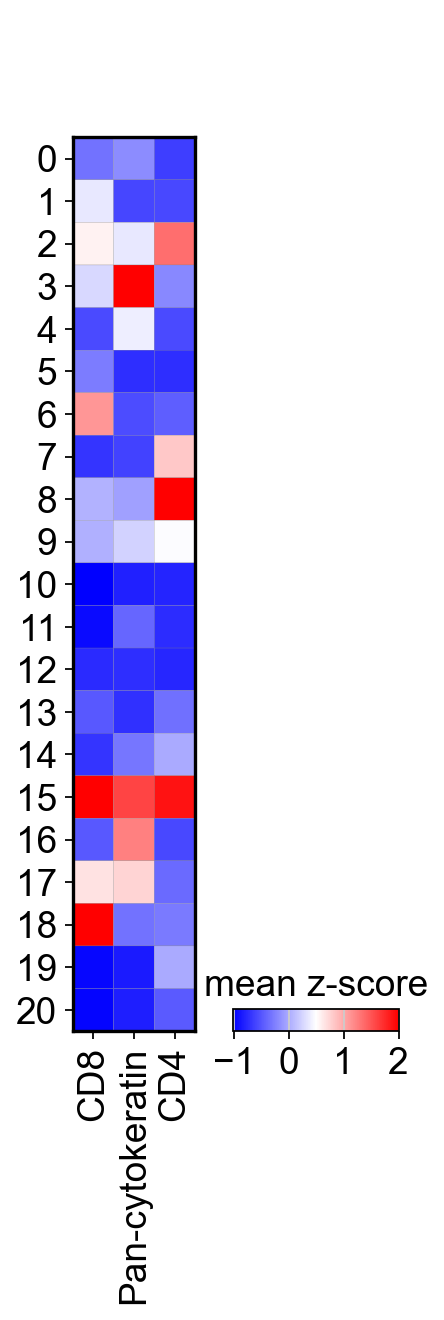

In [156]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.set_figure_params( fontsize=20)
ax_dict = sc.pl.matrixplot(adata, adata.var_names, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score', cmap='bwr', show=False, vmax=2)
ax_dict['mainplot_ax'].tick_params(axis='x', labelrotation=90)


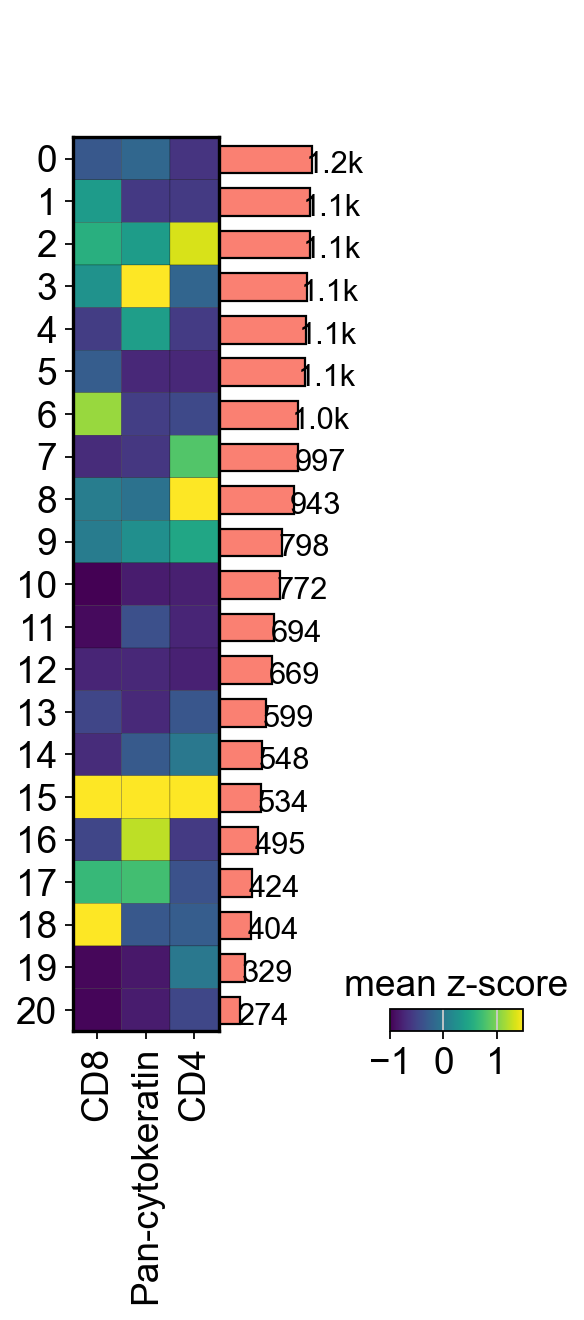

In [160]:
mp = sc.pl.matrixplot(adata, adata.var_names, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score',  cmap='bwr', vmax=1.5 , return_fig=True)
mp.add_totals(size=1.0).style(edge_color='black', ).show()

c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


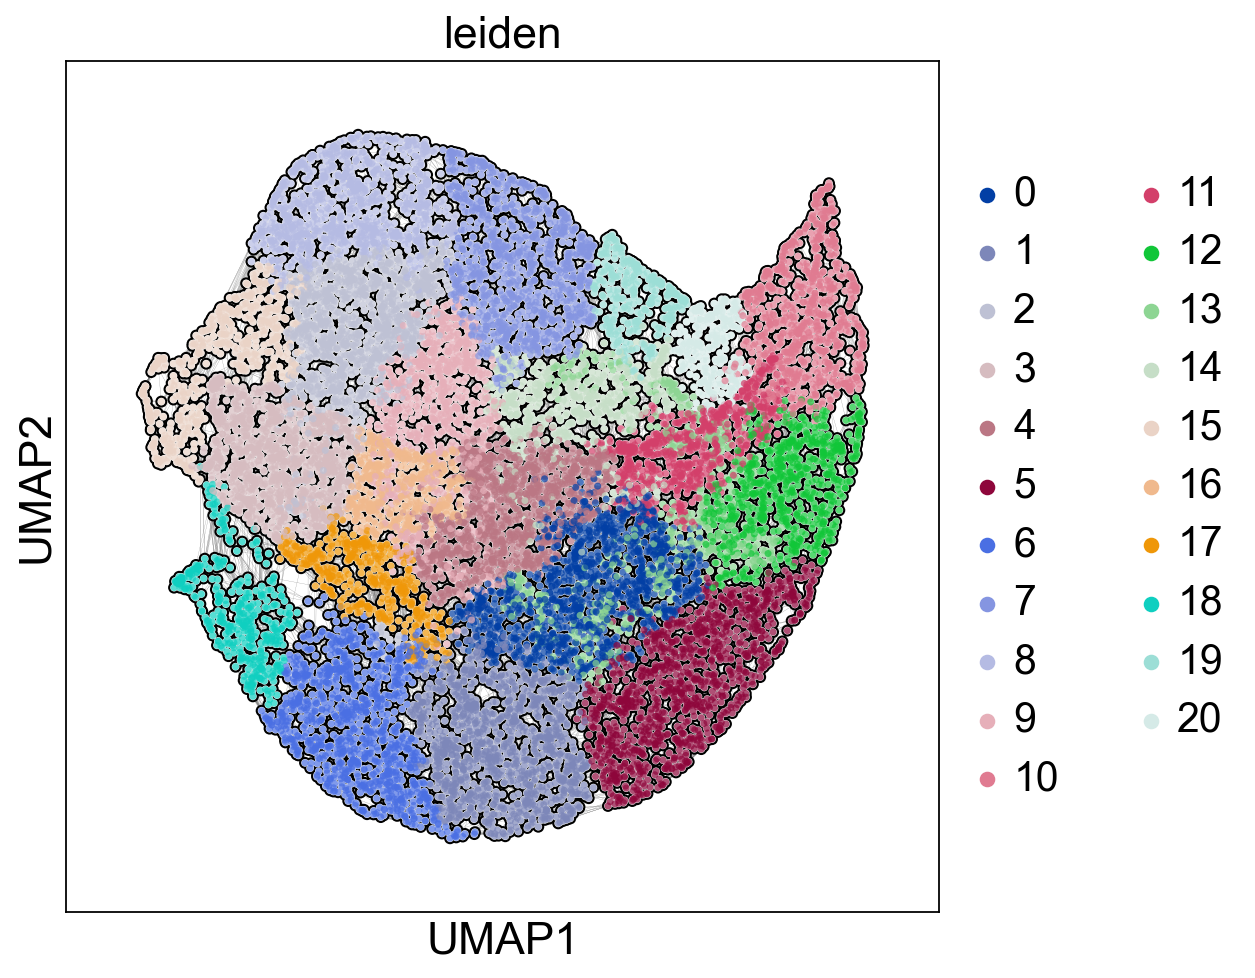

In [161]:
fig, ax = plt.subplots(figsize=(7,7))
sc.pl.umap(adata, color='leiden', ax=ax, size=40, edges=True, add_outline=True)

c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


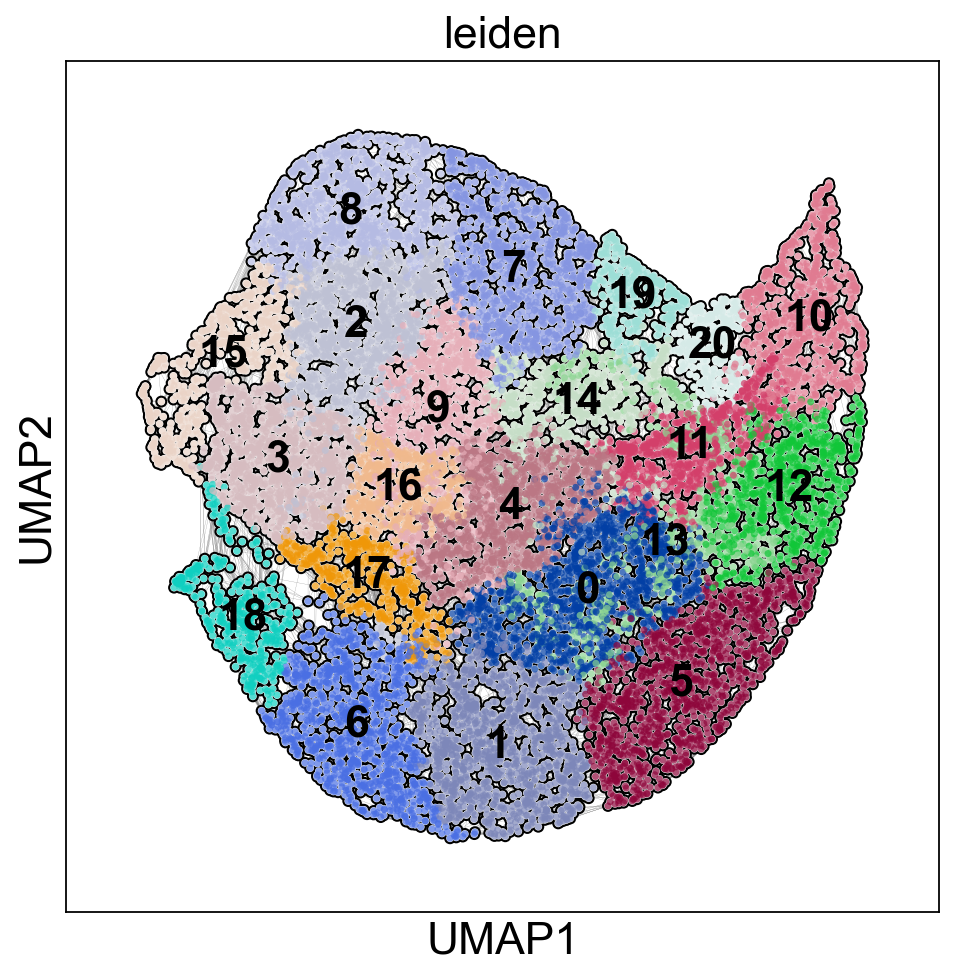

In [162]:
fig, ax = plt.subplots(figsize=(7,7))
sc.pl.umap(adata, color='leiden', ax=ax, size=40, edges=True, add_outline=True, legend_loc='on data')

In [163]:
# Define cell type
mapping = dict(zip(
    [str(i) for i in range(len(adata.obs.leiden.unique()))], 
    ['Other', 'Other', 'Other', 'PanCK+', 'Other', 'Other', 'Other', 'Other','CD4+', 'Other',
    'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'PanCK+', 'Other','CD8+', 'Other',
    'Other',]
))

# Define new clusters
adata.obs["Cell Type"] = (
    adata.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)

print(adata.obs["Cell Type"].unique())

['Other', 'CD4+', 'PanCK+', 'CD8+']
Categories (4, object): ['CD4+', 'CD8+', 'Other', 'PanCK+']


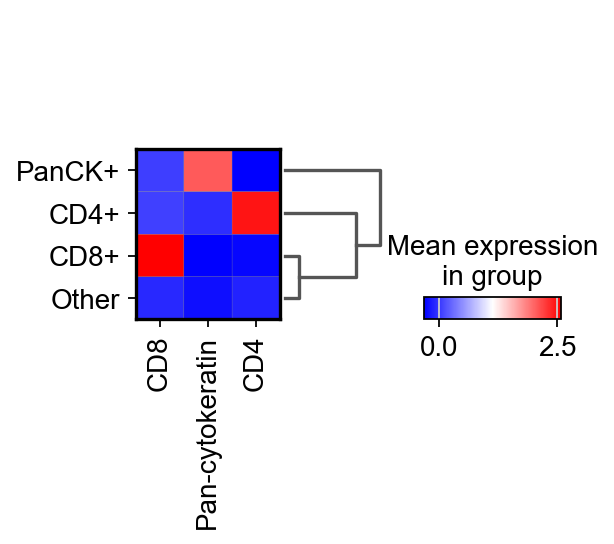

In [164]:
sc.set_figure_params( fontsize=15)

sc.tl.dendrogram(adata, groupby='Cell Type')
sc.pl.matrixplot(adata, adata.var_names, groupby='Cell Type', 
                 dendrogram=True, cmap='bwr')

c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\PLA2\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


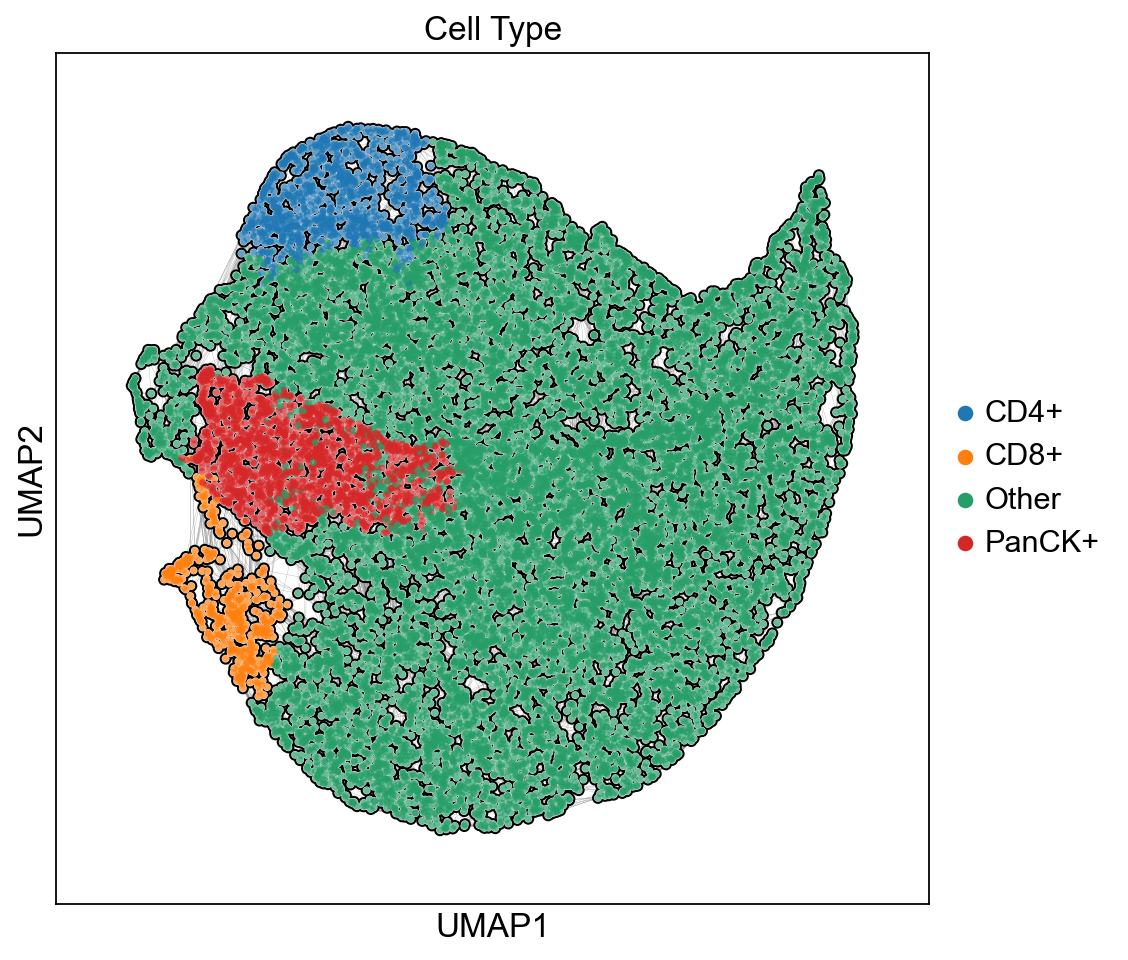

In [165]:
fig, ax = plt.subplots(figsize=(7,7))
sc.pl.umap(adata, color='Cell Type', ax=ax, size=40, edges=True, add_outline=True)

In [166]:
path = data_dir / 'tissue' / 'metadata' / 'cells.h5ad'
adata.write(path)

## Plot IF clustering results

In [167]:
import matplotlib 
from PIL import Image

def create_colored_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img

In [168]:
var = 'Cell Type'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

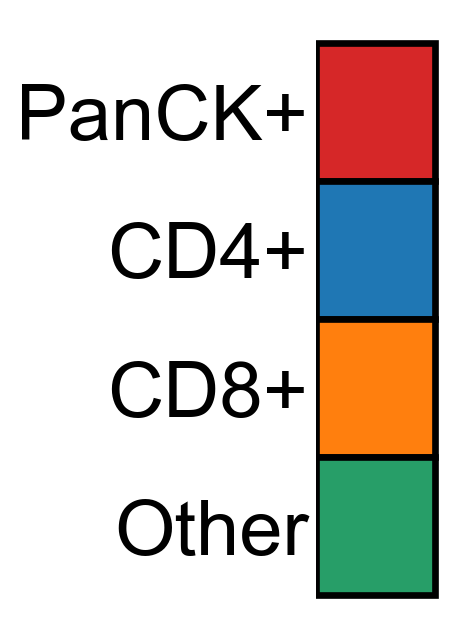

In [169]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [171]:
# Define figure file 
fig_path = fig_dir / 'tisse' / 'cell_type' 
fig_path.mkdir(parents=True, exist_ok=True)    

for d in adata.obs.Condition.unique():
    adata_donor = adata[adata.obs.Condition == d, :]
    
    # Read cell mask
    mask_path = mask_dir / f'{d}_cell.png'
    mask = skimage.io.imread(mask_path)

    # Get label2cell dict
    label2cell = {}
    for ii,l in enumerate(labels):
        cell_id = adata_donor[adata_donor.obs[var] == l].obs.Cell.to_list()
        label2cell[ii] = cell_id

    img = create_colored_cell(mask, label2cell, colors_rgb)

    save_path = fig_path / f"{d}.png"
    img = Image.fromarray(img)
    img.save(save_path)

## Compare to HE image segmentation results

In [7]:
import joblib 
from skimage import exposure

def read_seg(input):
    file_path = input[0]
    file_name = input[1]
    wsi_pred = joblib.load(f"{file_name}.dat")
    return file_path, wsi_pred

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (50, 99.9))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale


In [8]:
# Define output path from segmentation notebooks
wsi_output = [['Y:\\coskun-lab\\Thomas\\23_PLA_revision\\data\\tissue\\HE_reg_pyr\\577-1197_40X.ome.tif',
  'y:\\coskun-lab\\Thomas\\23_PLA_revision\\notebooks\\HE_wsi_results\\0'],
 ['Y:\\coskun-lab\\Thomas\\23_PLA_revision\\data\\tissue\\HE_reg_pyr\\577-1210_40X.ome.tif',
  'y:\\coskun-lab\\Thomas\\23_PLA_revision\\notebooks\\HE_wsi_results\\1']]

# Define color scheme
color_dict = {
    0: ("neoplastic epithelial", (255, 0, 0)),
    1: ("Inflammatory", (255,0,255)),
    2: ("Connective", (0, 255, 0)),
    3: ("Dead", (0, 0, 0)),
    4: ("non-neoplastic epithelial", (255, 0, 0)),
}

# Read information for HE segmentation pipeline
file_path, wsi_pred = read_seg(wsi_output[0])

# Convert info
scale = 1.32477612
centroids_x = []
centroids_y = []
types = []
for idx, [_, inst_info] in enumerate(wsi_pred.items()):
    inst_centroid = inst_info["centroid"]
    centroids_x.append(int(inst_centroid[0]*scale))
    centroids_y.append(int(inst_centroid[1]*scale))
    types.append(inst_info["type"])

df_HE = pd.DataFrame({'x': np.array(centroids_x), "y": np.array(centroids_y), 'type': np.array(types)})  

In [10]:
from skimage import color 

# Define HE dir
HE_dir = data_dir / 'tissue' / 'HE_registered'

# Define cell mask dir
mask_dir =  data_dir / 'tissue' / 'masks'

for row in df_imgs.itertuples():
    # Get info
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Get HE path
    HE_path = HE_dir / f'{name}.tif'
    HE_img = tiff.imread(HE_path)
    
    # Transform grayscale
    HE_img_gray = color.rgb2gray(HE_img)

    # Get IF images 
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    # Read cell mask
    mask_path = mask_dir / f'{row[1]}_cell.png'
    mask = skimage.io.imread(mask_path)
    break

In [11]:

IF_markers = ['CD8','Pan-cytokeratin','CD4']
imgs_subset = []
for i, m in enumerate(markers):
    if m in IF_markers:
        img = contrast_stretching(imgs[i])
        imgs_subset.append(img)

        

In [12]:
points = []
for t in df_HE.type.unique():
    points.append(df_HE[df_HE.type == t][['y', 'x']].values)

In [13]:
viewer = napari.view_image(np.stack(imgs_subset), name=IF_markers, channel_axis=0, contrast_limits=[0, 2**16])
viewer.add_image(HE_img)
viewer.add_labels(mask)

for i, point in enumerate(points):
    points_layer = viewer.add_points(point, size=20)
    points_layer.face_color = np.array(color_dict[i][1])/255

In [230]:
### Assign cell type based on centroid 
df_HEs = []
for wsi in wsi_output:
    # Read file
    file_path, wsi_pred = read_seg(wsi)

    # Get name of the condition
    data = wsi[0].split('\\')[-1].split('.')[0].split('_')[0]

    # Convert info
    scale = 1.32477612
    centroids_x = []
    centroids_y = []
    types = []
    for idx, [_, inst_info] in enumerate(wsi_pred.items()):
        inst_centroid = inst_info["centroid"]
        centroids_x.append(int(inst_centroid[0]*scale))
        centroids_y.append(int(inst_centroid[1]*scale))
        types.append(inst_info["type"])

    # Read cell mask
    mask_path = mask_dir / f'{data}_cell.png'
    mask = skimage.io.imread(mask_path)

    df_HE = pd.DataFrame({'x': np.array(centroids_x), "y": np.array(centroids_y), 'type': np.array(types), 'Cell_ID': mask[np.array(centroids_y), np.array(centroids_x)]})  
    df_HE['Condition'] = data
    df_HEs.append(df_HE)

In [232]:
df_HE = pd.concat(df_HEs)

In [235]:
df_HE.to_csv( data_dir / 'tissue' / 'metadata' / 'HE_cell_type.csv')

## Combine HE and IF

In [336]:
import scanpy as sc

In [337]:
# Read adata and HE prediction dataframe
path = data_dir / 'tissue' / 'metadata' / 'cells.h5ad'
adata = sc.read_h5ad(path)
df_obs = adata.obs.copy()

df_HE = pd.read_csv( data_dir / 'tissue' / 'metadata' / 'HE_cell_type.csv', index_col=0)
df_HE = df_HE.drop_duplicates(subset=['Condition', 'Cell_ID'], keep='first')

# Get number of type prediction
type_dict = {0: "Tumor",
    1: 'Immune',
    2: 'Stroma',
    3: 'Other',
    4: "Epithelial"}
df_HE['Prediction'] = df_HE['type'].apply(lambda x: type_dict.get(x, x))

# merge dataframe and fill NA
df_all = df_obs.merge(df_HE, left_on=['Condition', 'Cell'], right_on=['Condition', 'Cell_ID'], how='left')
df_all['Prediction'] = df_all['Prediction'].fillna('Other')

df_all['Cell Type'] = df_all['Cell Type'].astype(str)

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\pandas\core\arrays\categorical.py:555: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


In [338]:
df_all.loc[df_all['Cell Type'] == 'Other', 'Cell Type'] = df_all.loc[df_all['Cell Type'] == 'Other']['Prediction']
df_all['Cell Type'] = df_all['Cell Type'].astype('category')

In [339]:
df_all['Cell Type'].unique()

['Other', 'CD4+', 'PanCK+', 'CD8+', 'Stroma', 'Tumor', 'Epithelial', 'Immune']
Categories (8, object): ['CD4+', 'CD8+', 'Epithelial', 'Immune', 'Other', 'PanCK+', 'Stroma', 'Tumor']

In [340]:
adata.obs = df_all

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


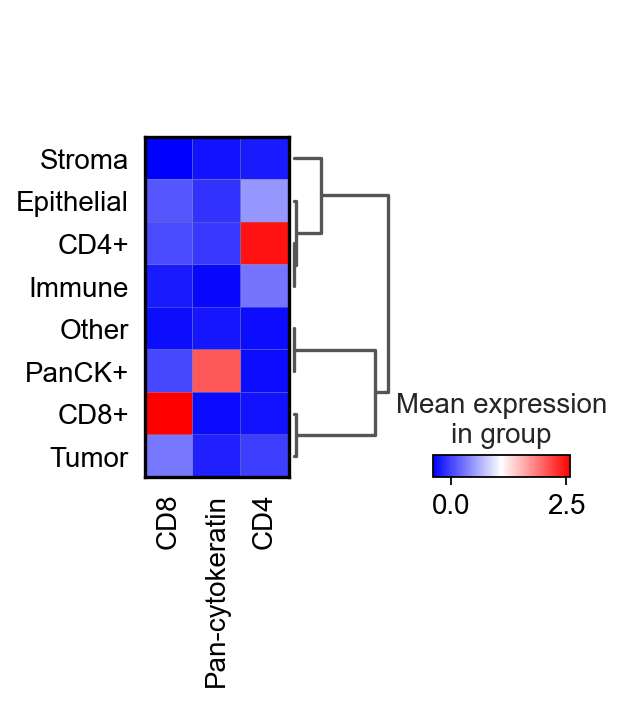

In [341]:
sc.set_figure_params( fontsize=15)

sc.tl.dendrogram(adata, groupby='Cell Type')
sc.pl.matrixplot(adata, adata.var_names, groupby='Cell Type', 
                 dendrogram=True, cmap='bwr')

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


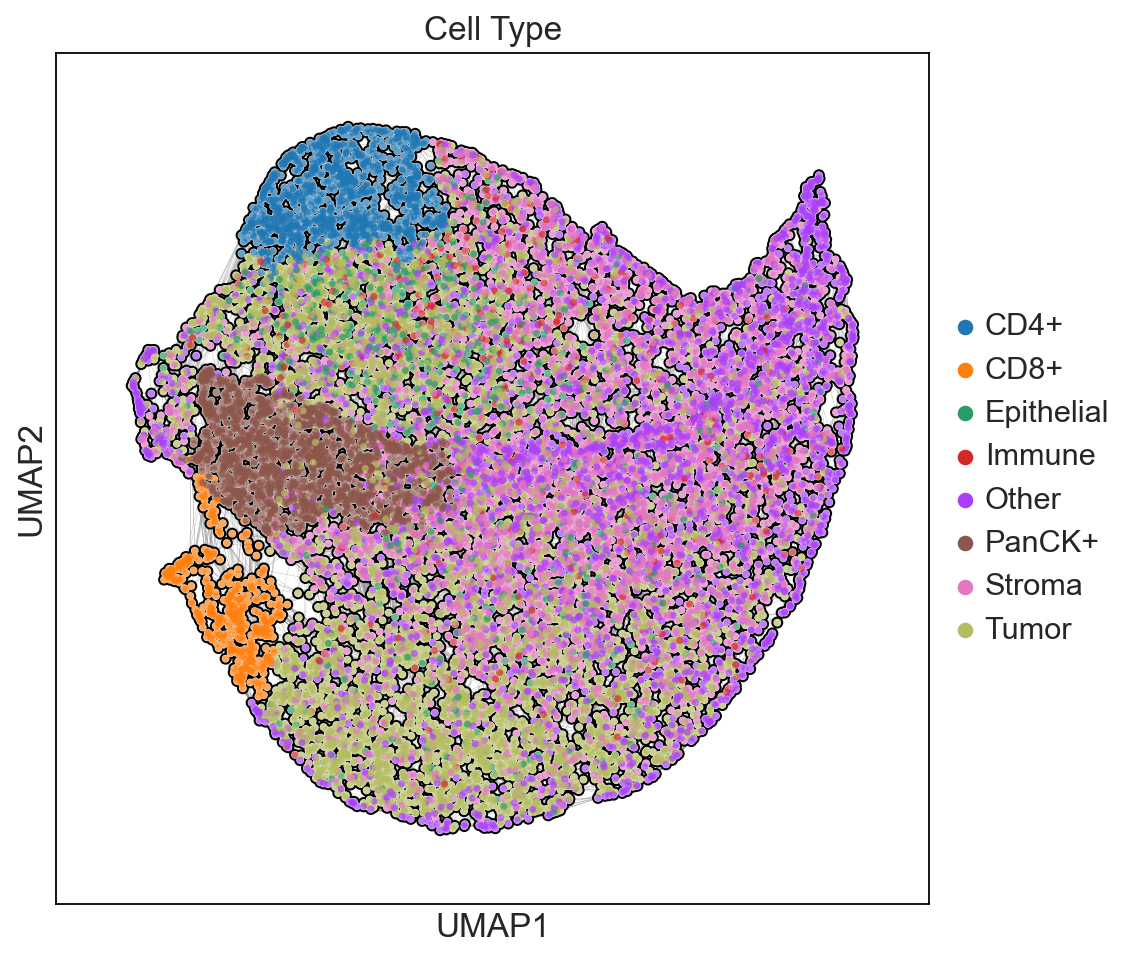

In [342]:
fig, ax = plt.subplots(figsize=(7,7))
sc.pl.umap(adata, color='Cell Type', ax=ax, size=40, edges=True, add_outline=True)

In [343]:
import matplotlib 
from PIL import Image

def create_colored_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img

In [344]:
var = 'Cell Type'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

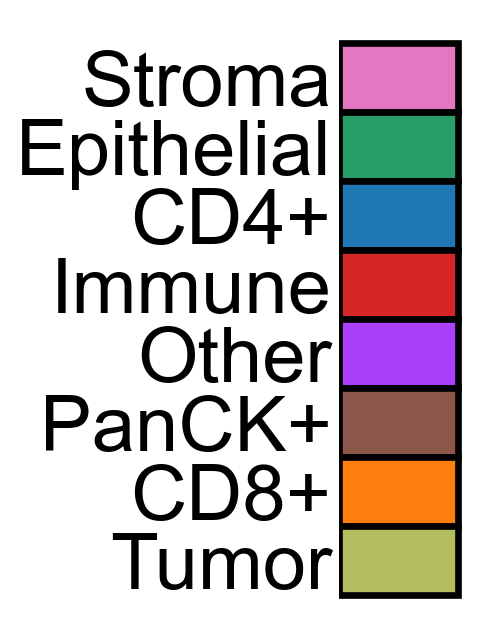

In [345]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [ ]:
# Define figure file 
fig_path = fig_dir / 'tisse' / 'cell_type' 
fig_path.mkdir(parents=True, exist_ok=True)    

# Define cell mask dir
mask_dir =  data_dir / 'tissue' / 'masks'

for d in adata.obs.Condition.unique():
    adata_donor = adata[adata.obs.Condition == d, :]
    
    # Read cell mask
    mask_path = mask_dir / f'{d}_cell.png'
    mask = skimage.io.imread(mask_path)

    # Get label2cell dict
    label2cell = {}
    for ii,l in enumerate(labels):
        cell_id = adata_donor[adata_donor.obs[var] == l].obs.Cell.to_list()
        label2cell[ii] = cell_id

    img = create_colored_cell(mask, label2cell, colors_rgb)

    save_path = fig_path / f"{d}_combined.png"
    img = Image.fromarray(img)
    img.save(save_path)

In [347]:
# path = data_dir / 'tissue' / 'metadata' / 'cells_combined.h5ad'
# adata.write(path)

In [348]:
map_dict = {'PanCK+': 'Tumor', 'Stroma': 'Stroma', 'CD4+':'Immune', 'Epithelial':'Tumor', 'CD8+':'Immune'}

adata.obs['Cell Type 2'] = adata.obs['Cell Type'].apply(lambda x: map_dict.get(x,x))
adata.obs['Cell Type 2'] = adata.obs['Cell Type 2'].astype('category')

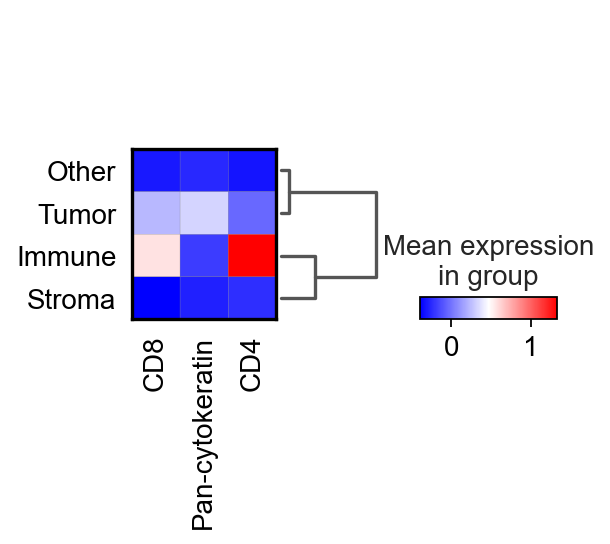

In [349]:
sc.set_figure_params( fontsize=15)

sc.tl.dendrogram(adata, groupby='Cell Type 2')
sc.pl.matrixplot(adata, adata.var_names, groupby='Cell Type 2', 
                 dendrogram=True, cmap='bwr')

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


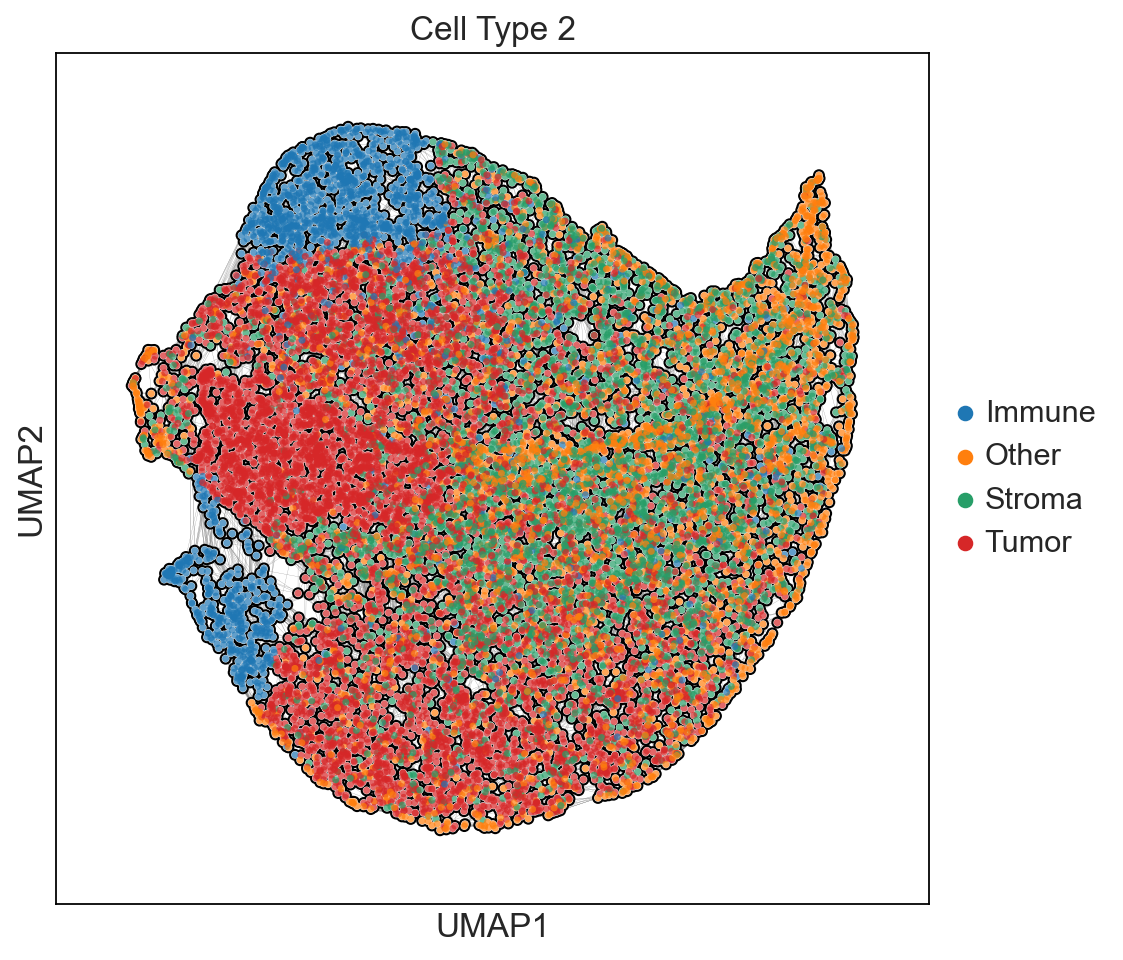

In [350]:
fig, ax = plt.subplots(figsize=(7,7))
sc.pl.umap(adata, color='Cell Type 2', ax=ax, size=40, edges=True, add_outline=True)

In [29]:
var = 'Cell Type 2'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

KeyError: 'dendrogram_Cell Type 2'

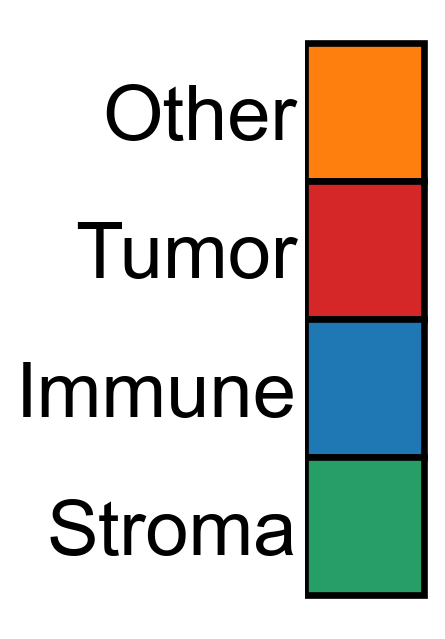

In [352]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [28]:
colors_rgb_dict_cell = colors_rgb_dict.copy()

NameError: name 'colors_rgb_dict' is not defined

In [203]:
# Define figure file 
fig_path = fig_dir / 'tisse' / 'cell_type' 
fig_path.mkdir(parents=True, exist_ok=True)    

# Define cell mask dir
mask_dir =  data_dir / 'tissue' / 'masks'

for d in adata.obs.Condition.unique():
    adata_donor = adata[adata.obs.Condition == d, :]
    
    # Read cell mask
    mask_path = mask_dir / f'{d}_cell.png'
    mask = skimage.io.imread(mask_path)

    # Get label2cell dict
    label2cell = {}
    for ii,l in enumerate(labels):
        cell_id = adata_donor[adata_donor.obs[var] == l].obs.Cell.to_list()
        label2cell[ii] = cell_id

    img = create_colored_cell(mask, label2cell, colors_rgb)

    save_path = fig_path / f"{d}_combined_2.png"
    img = Image.fromarray(img)
    img.save(save_path)

# Visual examples

In [354]:
import pickle 
from sklearn.neighbors import NearestNeighbors
from skimage import measure 
import vispy 
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def get_loc_ppi(df, Condition, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [355]:
# Create PPI dataframe
PPI_save_path =  data_dir / 'tissue' / 'PPI'
df_PPIs = []

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

    dfs_PPI_cyto = []
    
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        df_PPI = pd.DataFrame(PPI_loc, 
                      columns=['x', 'y'])
        df_PPI['PPI'] = k
        df_PPI['Condition'] = row[1]
        df_PPIs.append(df_PPI)

df_PPI = pd.concat(df_PPIs)
df_PPI.columns = [ 'row', 'column',  'PPI', 'Condition']
df_PPI.head()

row  column        PPI Condition
0   988   11013  Sox2/Oct4  577-1197
1  2427   10828  Sox2/Oct4  577-1197
2    73    7263  Sox2/Oct4  577-1197
3  2717    7532  Sox2/Oct4  577-1197
4  1610    6585  Sox2/Oct4  577-1197

In [356]:
# Read HE image
HE_dir =data_dir /'tissue'/'HE_reg_pyr'

# Get list of PPI name
PPIs = df_PPI.PPI.unique()

[array(['Cyclin D1/CDK4', 'Cyclin E/CDK2', 'NF-Kb/p-P90rsk', 'Sox2/Oct4',
       'TRAIL/DR5'], dtype=object)]


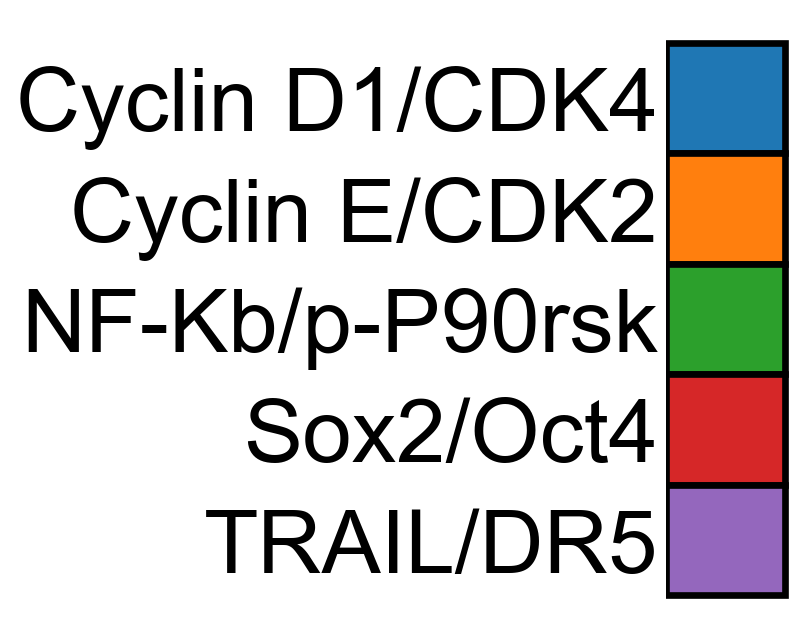

In [357]:
# Get colors
import palettable
from sklearn.preprocessing import OneHotEncoder

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df_PPI['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df_PPI['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_10.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [358]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

# Read HE image
img = skimage.io.imread(HE_dir / f'{row[0]}_{row[1]}.ome.tif')

Condition                                             577-1197
FOV                                                        40X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 1, dtype: object


In [359]:
# Define matching bbox to figures
x_min, y_min = 1744, 2100
x_max, y_max = 3529, 3524

In [360]:
adata_donor = adata[adata.obs.Condition == row.Condition, :]
# Read cell mask
mask_path = mask_dir / f'{row.Condition}_cell.png'
mask = skimage.io.imread(mask_path)
# Get label2cell dict
color_dict = {}
for row in adata_donor.obs.itertuples():
    color = colors_rgb_dict_cell [row[-1]]
    rgba = np.array([color[0], color[1], color[2], 255])
    color_dict [row.Cell] = rgba

In [364]:
points = [get_loc_ppi(df_PPI, row.Condition, x_min, y_min, x_max, y_max, PPI_name) 
          for PPI_name in PPIs]
viewer = napari.view_image(img[y_min:y_max, x_min:x_max, :])
label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color_dict , opacity=0.5)


C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\utils\colormaps\standardize_color.py:296: UserWarning: Colors with values larger than one detected. napari will normalize these colors for you. If you'd like to convert these yourself, please use the proper method from skimage.color.
  warnings.warn(


In [368]:
points = [get_loc_ppi(df_PPI, row.Condition, x_min, y_min, x_max, y_max, PPI_name) 
          for PPI_name in PPIs]
viewer = napari.view_image(img[y_min:y_max, x_min:x_max, :])
label = viewer.add_labels(mask[y_min:y_max, x_min:x_max], color=color_dict , opacity=0.9)
label.contour = 3
for i, point in enumerate(points):
    red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
    points_layer = viewer.add_points(point, size=15)
    points_layer.face_color = colors_rgb_dict[PPIs[i]]/255

C:\Users\thu71\AppData\Roaming\Python\Python311\site-packages\napari\utils\colormaps\standardize_color.py:296: UserWarning: Colors with values larger than one detected. napari will normalize these colors for you. If you'd like to convert these yourself, please use the proper method from skimage.color.
  warnings.warn(


# Statistics

## Comparison condition

In [7]:
# Read PPI
PPI_save_path =  data_dir / 'tissue' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

# Combine count
df_all = df_cell

In [8]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count      mean       std  min  25%  50%  75%   max
Condition PPI                                                                 
577-1197  Cyclin D1/CDK4  7639.0  0.076450  0.290676  0.0  0.0  0.0  0.0   4.0
          Cyclin E/CDK2   7639.0  0.008116  0.098094  0.0  0.0  0.0  0.0   3.0
          NF-Kb/p-P90rsk  7639.0  0.717371  0.992694  0.0  0.0  0.0  1.0   9.0
          Sox2/Oct4       7639.0  2.821050  2.372277  0.0  1.0  2.0  4.0  25.0
          TRAIL/DR5       7639.0  0.014662  0.124483  0.0  0.0  0.0  0.0   2.0
577-1210  Cyclin D1/CDK4  3660.0  0.282240  0.549652  0.0  0.0  0.0  0.0   6.0
          Cyclin E/CDK2   3660.0  0.007650  0.090224  0.0  0.0  0.0  0.0   2.0
          NF-Kb/p-P90rsk  3660.0  0.604098  0.946410  0.0  0.0  0.0  1.0  14.0
          Sox2/Oct4       3660.0  1.051913  1.230271  0.0  0.0  1.0  1.0  16.0
          TRAIL/DR5       3660.0  0.400000  0.789103  0.0  0.0  0.0  1.0  13.0

In [9]:
# Filter out by maximum number of counts per cell
min_count = 3
max_count = 10

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


C:\Users\thu71\AppData\Local\Temp\ipykernel_61684\927022389.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


Count_cell
count  3539.000000
mean      5.831308
std       2.045849
min       4.000000
25%       4.000000
50%       5.000000
75%       7.000000
max      21.000000

In [15]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_clipboard()

In [11]:
df_all['Condition_name'] = df_all['Condition'].apply(lambda x: {'577-1197': 'Responder', '577-1210': 'Non responder'}.get(x,x)) 

In [12]:
from statannotations.Annotator import Annotator

sns.set_style('white')
def plot(plotting, figsize=(5,6), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        # ax = sns.violinplot(**plotting, showfliers=False, ax=ax,  bw=1, cut=0)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', comparisons_correction = 'Bonferroni', text_format='star', loc='outside', verbose=2)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E/CDK2_Non responder vs. Cyclin E/CDK2_Responder: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.652e-01 U_stat=9.135e+05
Cyclin D1/CDK4_Non responder vs. Cyclin D1/CDK4_Responder: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.072e-87 U_stat=1.202e+06
NF-Kb/p-P90rsk_Non responder vs. NF-Kb/p-P90rsk_Responder: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.661e-06 U_stat=1.016e+06
Sox2/Oct4_Non responder vs. Sox2/Oct4_Responder: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.266e-137 U_stat=3.372e+05
TRAIL/DR5_Non responder vs. TRAIL/DR5_Responder: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=1.435e+06


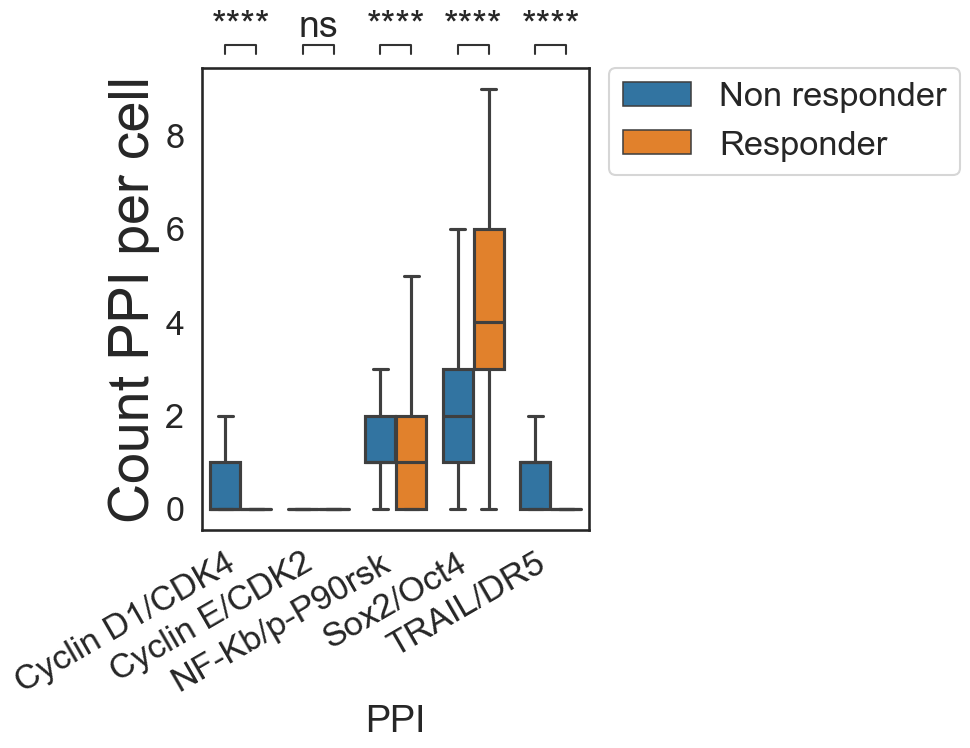

In [13]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition_name", 
    "hue_order": ['Non responder', 'Responder']
}

plot(plotting)

## Cell type

In [17]:
import scanpy as sc

In [18]:
# Read adata and HE prediction dataframe
path = data_dir / 'tissue' / 'metadata' / 'cells_combined.h5ad'
adata = sc.read_h5ad(path)
df_obs = adata.obs.copy()

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
# Merge PPI count dataframe with Cell type adata
df_all['Id'] = df_all['Id'].astype(int)
df_merged = df_all.merge(df_obs, left_on=['Condition', 'Id'], right_on=['Condition', 'Cell'], how='left')

# Rename to class
map_dict = {'PanCK+': 'Tumor', 'Stroma': 'Stroma', 'CD4+':'Immune', 'Epithelial':'Tumor', 'CD8+':'Immune'}
df_merged['Class'] = df_merged['Cell Type'].apply(lambda x: map_dict.get(x,x))
df_merged.head()


Condition  FOV  Id             PPI  Count_cell Condition_name  Cell leiden  \
0  577-1197  40X  36  Cyclin D1/CDK4         0.0      Responder    36      7   
1  577-1197  40X  38  Cyclin D1/CDK4         0.0      Responder    38      0   
2  577-1197  40X  39  Cyclin D1/CDK4         0.0      Responder    39      4   
3  577-1197  40X  66  Cyclin D1/CDK4         0.0      Responder    66      7   
4  577-1197  40X  67  Cyclin D1/CDK4         0.0      Responder    67     12   

  Cell Type   x   y  type  Cell_ID Prediction  Class  
0     Other NaN NaN   NaN      NaN      Other  Other  
1     Other NaN NaN   NaN      NaN      Other  Other  
2     Other NaN NaN   NaN      NaN      Other  Other  
3     Other NaN NaN   NaN      NaN      Other  Other  
4     Other NaN NaN   NaN      NaN      Other  Other

In [20]:
df_merged['Class'].value_counts()

Tumor     9880
Stroma    4800
Other     1660
Immune    1355
Name: Class, dtype: int64

In [21]:
df_merged['Condition'] = df_merged['Condition'].apply(lambda x: {'577-1197': 'Responder', '577-1210': 'Non responder'}.get(x,x)) 

In [22]:
df_merged.Condition.unique()

array(['Responder', 'Non responder'], dtype=object)

In [23]:
df_merged['Condition'].unique()

array(['Responder', 'Non responder'], dtype=object)

In [24]:
df_merged['Class'].unique()

array(['Other', 'Stroma', 'Tumor', 'Immune'], dtype=object)

In [25]:
palette = {k:v/255 for k,v in colors_rgb_dict_cell.items()}

NameError: name 'colors_rgb_dict_cell' is not defined

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E/CDK2_Tumor vs. Cyclin E/CDK2_Immune: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.370e-01
NF-Kb/p-P90rsk_Tumor vs. NF-Kb/p-P90rsk_Immune: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.175e+00
Sox2/Oct4_Tumor vs. Sox2/Oct4_Immune: t-test independent samples with Bonferroni correction, P_val:8.567e-06 t=5.019e+00
TRAIL/DR5_Tumor vs. TRAIL/DR5_Immune: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.307e-01
NF-Kb/p-P90rsk_Stroma vs. NF-Kb/p-P90rsk_Tumor: t-test independent samples with Bonferroni correction, P_val:2.126e-02 t=-3.195e+00
Sox2/Oct4_Stroma vs. Sox2/Oct4_Tumor: t-test independent samples with Bonferroni correction, P_val:6.562e-13 t=-7.593e+00
TRAIL/DR5_Stroma vs. TRAIL/DR5_Tumor: t-test indepe

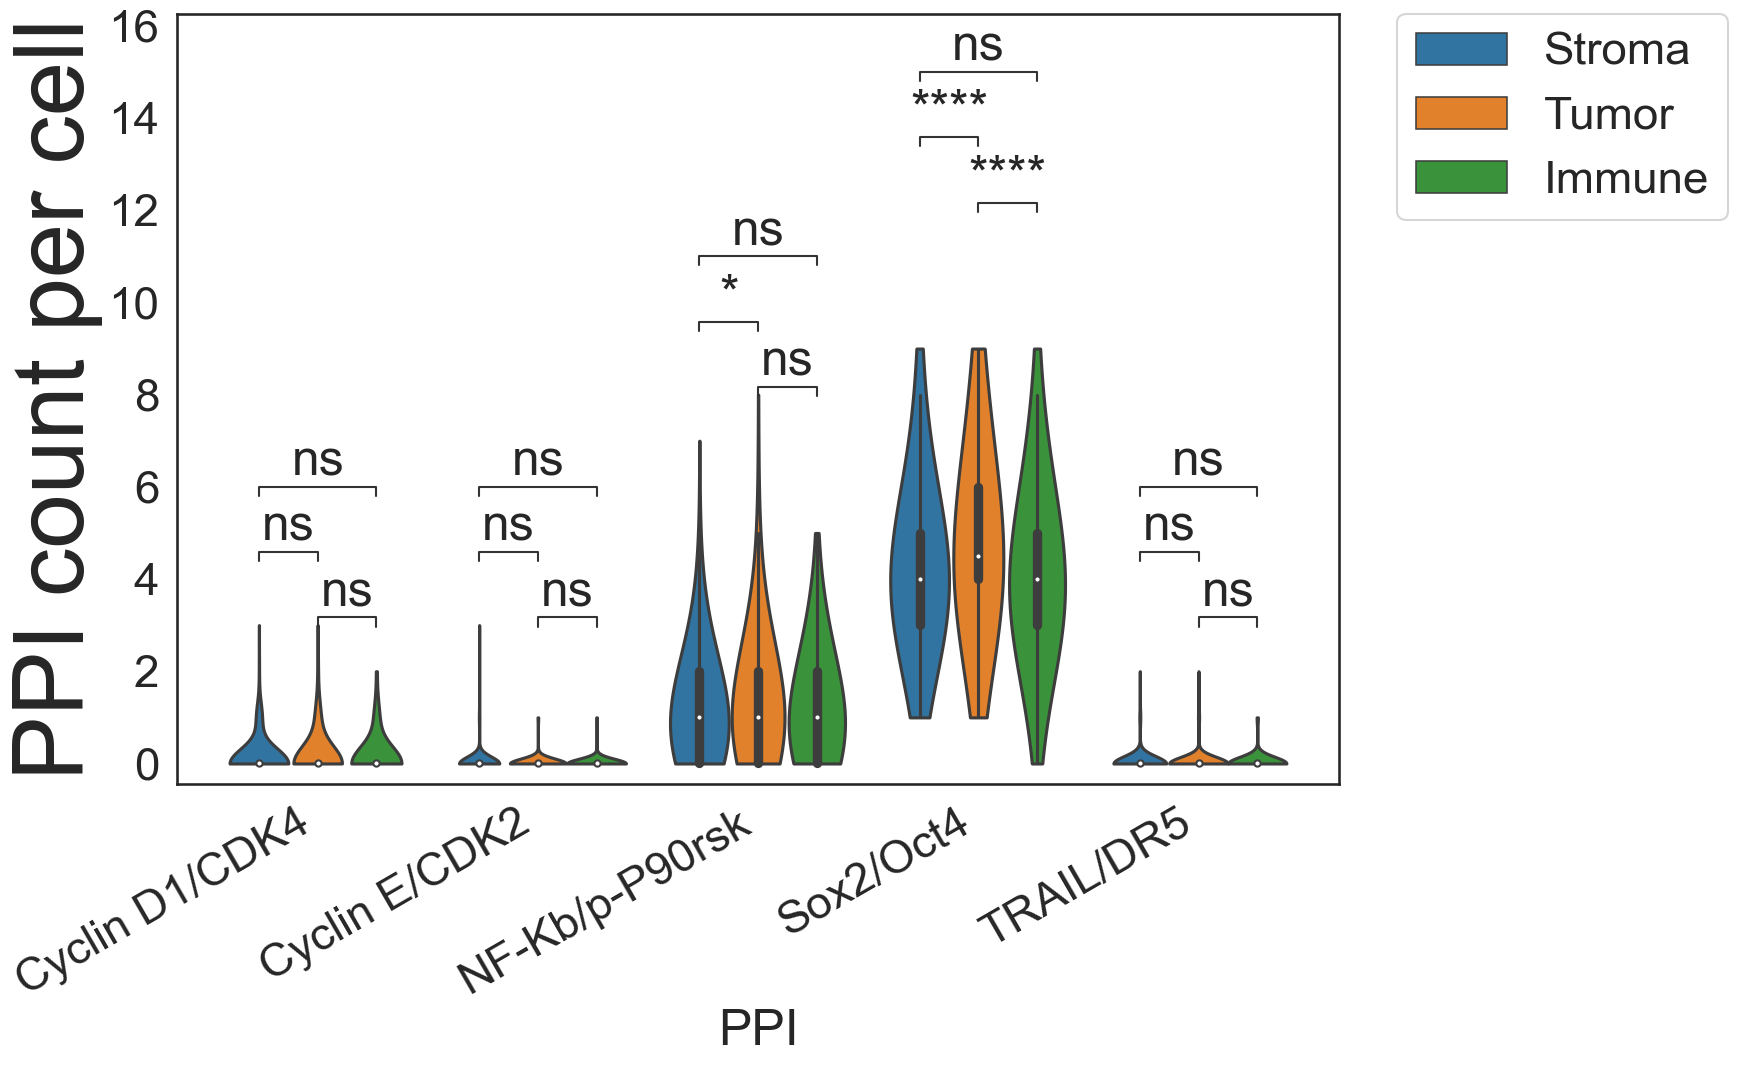

In [26]:
# Boxplot per cell
plotting = {
    "data": df_merged[(df_merged['Condition'] == 'Responder') & (df_merged['Class'] != 'Other')],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Class"
}

pairs = [((e, 'Tumor'), (e, 'Immune')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Tumor'), (e, 'Stroma')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Stroma'), (e, 'Immune')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.violinplot(**plotting, showfliers=False, ax=ax, bw=1, 
                        # palette=palette, 
                        cut=0)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
    result = annot.apply_test().annotate(line_offset_to_group=0.3)
    ax.set_ylabel('PPI count per cell', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [27]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

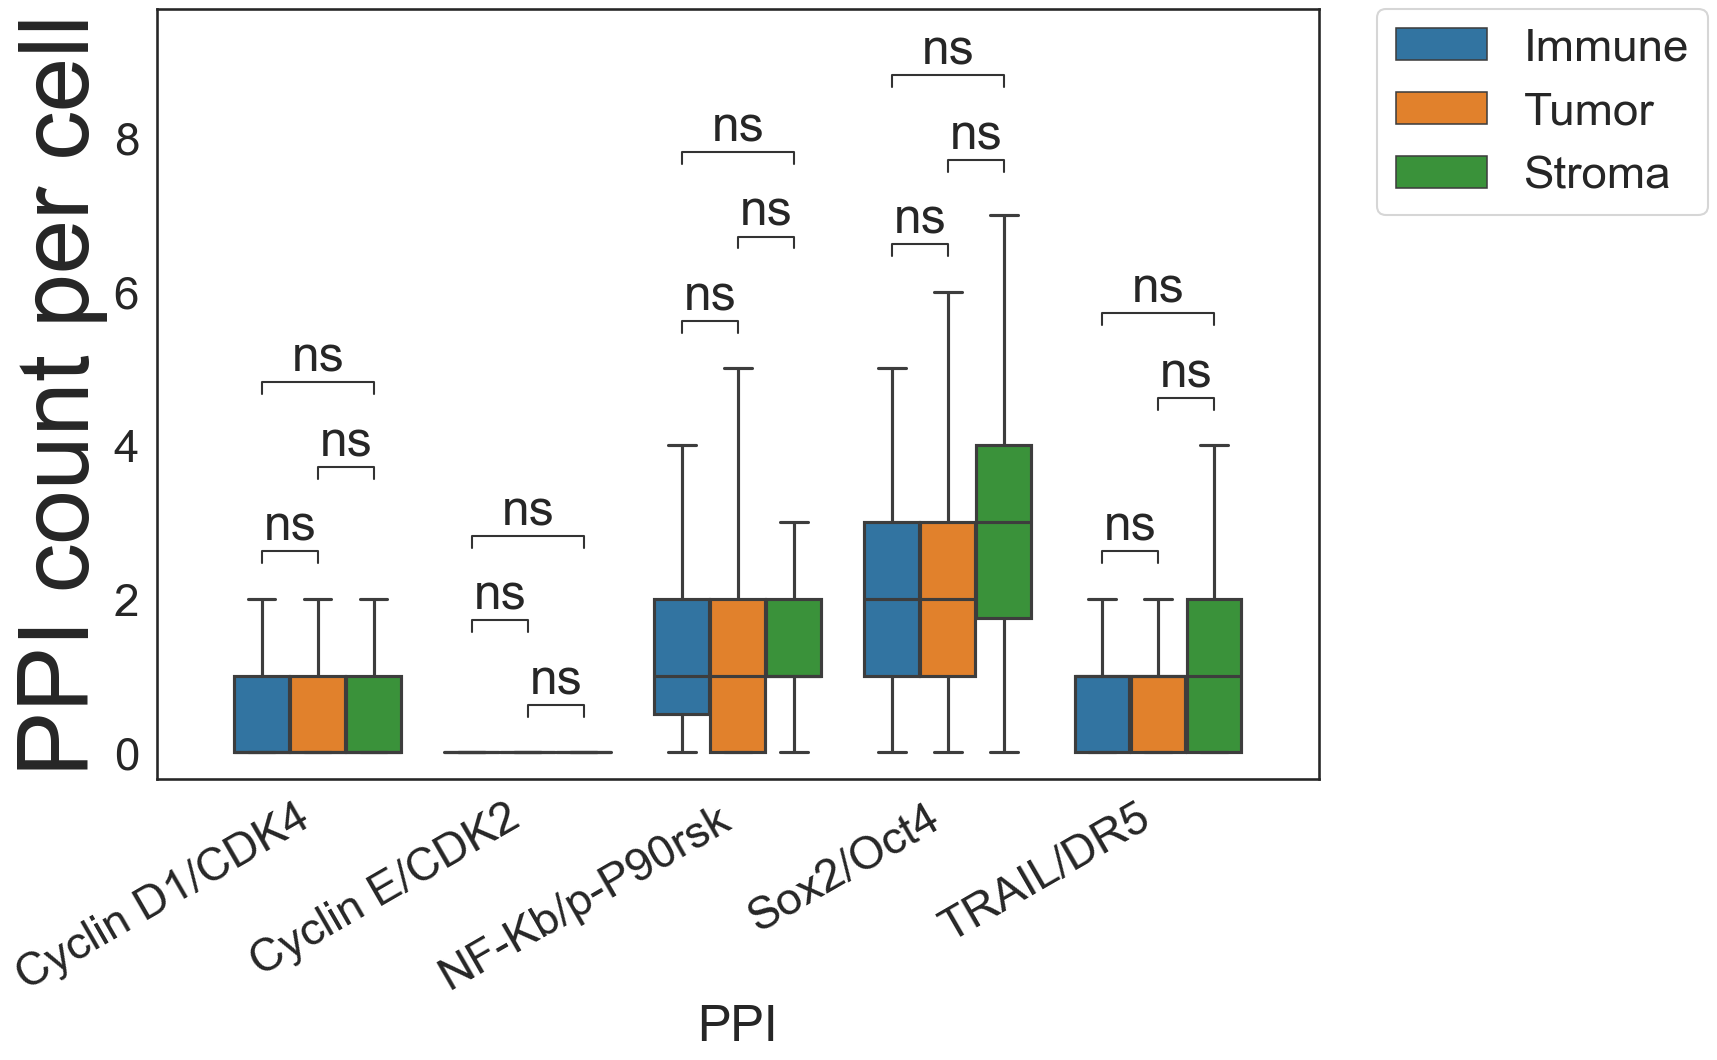

In [ ]:
# Boxplot per cell
plotting = {
    "data": df_merged[(df_merged['Condition'] == 'Non responder') & (df_merged['Class'] != 'Other')],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Class"
}

pairs = [((e, 'Tumor'), (e, 'Immune')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Tumor'), (e, 'Stroma')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Stroma'), (e, 'Immune')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax,)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI count per cell', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

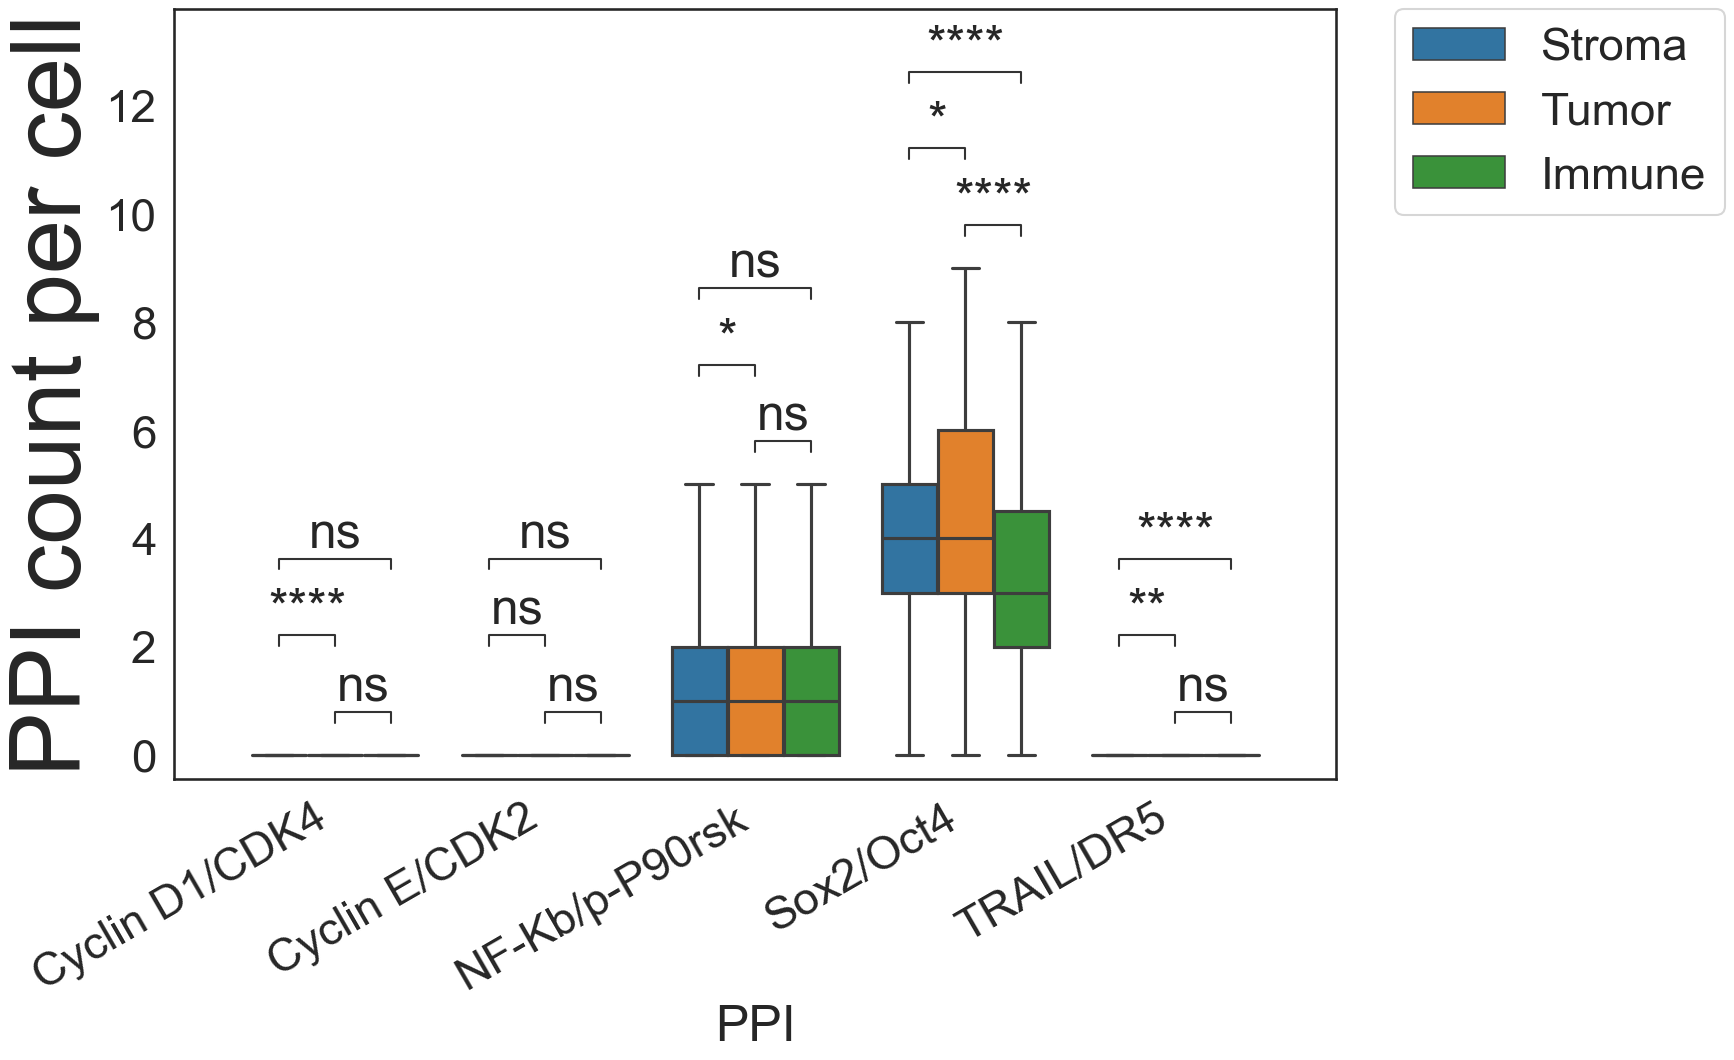

In [32]:
# Boxplot per cell
plotting = {
    "data": df_merged[df_merged['Class'] != 'Other'],
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Class"
}

pairs = [((e, 'Tumor'), (e, 'Immune')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Tumor'), (e, 'Stroma')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'Stroma'), (e, 'Immune')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15,10))
    # ax = sns.violinplot(**plotting, showfliers=False, ax=ax,  bw=1, cut=0)
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='t-test_ind', comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI count per cell', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)